# Solving the quantum many-body problem with NQS
## 1D transverse field Ising model chain

Specify the number of sites $N$, the size of the neural network $\alpha$ and the field $h$:

In [1]:
import numpy as np

def random_complex(size):
    a = (np.random.random(size) - .5) * 10e-2
    b = (np.random.random(size) - .5) * 10e-2
    return a + 1j*b

N = 4
alpha = 2
M = alpha * N
hfield = 2
a = random_complex(N)
b = random_complex(M)
W = random_complex((N,M))
state = np.random.randint(2, size=N)
state[state == 0] = -1
state_i = list(range(N))

NQS provides our trial wave function / ansatz:
$$\Psi_M(\mathcal{S})=e^{\sum_i^Na_j\sigma_j^z}\prod_{j}^M2\cosh\left(\theta_j\right)$$
with $\theta_j(\mathcal{S})=b_j\sum_{i}^NW_{ij}h_i\sigma_i^z$ (called effective angles in the paper).

In [2]:
def effective_angles(state):
    return b+np.inner(np.transpose(W),state)

def Psi_M(state,a,b,W):
    return np.exp(np.inner(a,state)) * np.prod(2*np.cosh(effective_angles(state)))

For the 1D transverse field Ising model:
$$H_{\text{TFI}}=-h\sum_i \sigma_i^x - \sum_{ij}\sigma_i^z\sigma_j^z,$$
with the Pauli matrices,
$$\sigma^x=\begin{pmatrix}
0 & 1\\
1 & 0
\end{pmatrix}\quad
\sigma^z=\begin{pmatrix}
1 & 0\\
0 & -1
\end{pmatrix}.$$

Calculating the local energy for a state $\mathcal{S}$,

$$E_\text{loc}=\frac{\left<\mathcal{S}\right|H\left|\Psi_M\right>}{\Psi_M(\mathcal{S})}$$
use
$$\left|\Psi_M\right>=\sum_{s'}\Psi_M(s')\left|s'\right>\quad\left<s,s'\right>=\delta_{ss'}$$
to find:

In [3]:
def E_loc(state):
    E = 0
    # \sigma^z part
    for i in state_i:
        if i == N-1:
            E-=(state[i]*state[0])
        else:
            E-=(state[i]*state[i+1])

    # \sigma^x part
    Psi_M_s = Psi_M(state,a,b,W)
    for i in state_i:
        state[i] *= -1
        E -= -hfield*Psi_M(state,a,b,W)/Psi_M_s
        state[i] *= -1 # flip back

    return E/N

## Quantum Monte Carlo Simulation
Acceptance of a new configuration:
$$P(\text{accept})=\frac{\Psi_M(\mathcal{S}_\text{new})\Psi^*_M(\mathcal{S}_\text{new})}{\Psi_M(\mathcal{S}_\text{old})\Psi^*_M(\mathcal{S}_\text{old})}$$

In [4]:
def step():
    # Choose random sites to be flipped
    sites = np.random.choice(state_i,1)
    Psi_M_before = Psi_M(state,a,b,W)
    for i in sites:
        state[i] *= -1 # flip
    Psi_M_after = Psi_M(state,a,b,W)
    acceptance = np.real(Psi_M_after*np.conj(Psi_M_after)/(Psi_M_before*np.conj(Psi_M_before)))

    if acceptance < np.random.uniform():
        for i in sites:
            state[i] *= -1 # flip back
        return 1 # return 1 to count # of rejections
    else:
        return 0

Keep track of $\nabla_\mathcal{W}E_\text{loc}$ and use these to update $\mathcal{W}=\{a,b,W\}$

$$\nabla_\mathcal{W}\left<E\right>=\nabla_\mathcal{W}\sum_{s}E_\text{loc}P(s)=\sum_{s}P(s)\nabla_\mathcal{W}E_\text{loc}+E_\text{loc}\nabla_\mathcal{W}P(s)$$
In this simulation we only keep track of the first term:
$$
\partial_{aj}E_\text{loc}(S)=-h\frac{\Psi_M(S_\text{flip i})}{\Psi_M(S)}\left[-2\sigma_j^z\right]
$$
$$
\partial_{bj}E_\text{loc}(S)=-h\sum_{i}^N\frac{\Psi_M(S_\text{flip i})}{\Psi_M(S)}\left[\tanh{\theta_j(S_\text{flip i})}-\tanh{\theta_j(S)}\right]
$$
$$
\partial_{W_{ij}}E_\text{loc}(S)=-h\sum_{i}^N\frac{\Psi_M(S_\text{flip i})}{\Psi_M(S)}\left[-\theta_i^z\tanh{\theta_j(S_\text{flip i})}-\theta_i^z\tanh{\theta_j(S)}\right]
$$

In [5]:
block_E = []
for block_i in range(30):
    state = np.random.randint(2, size=N)
    state[state == 0] = -1
    for k in range(10000):
        step()
    
    iterations = 20000
    rejected = 0
    array_E_loc = []
    
    array_a_d = []
    array_b_d = []
    array_w_d = []

    for k in range(iterations):
        rejected += step()
        
        if k % 100 == 0:
            Psi_M_s = Psi_M(state,a,b,W)
            
            # Derivative a
            a_deriv = np.zeros(N, dtype=np.complex_)
            for i in range(N):
                state[i] *= -1 # flip
                a_deriv[i] = -hfield*Psi_M(state,a,b,W)/Psi_M_s*2.*state[i]
                state[i] *= -1 # flip back
            
            # Derivative W
            dW = np.zeros((N,M),dtype=np.complex_)
            for w_i in range(N):
                for w_j in range(M):
                    dw_sum = 0
                    before_flip = np.tanh(effective_angles(state))
                    for i in range(N):
                        state[i] *= -1 # flip
                        dw_sum += Psi_M(state,a,b,W)/Psi_M_s*(
                            -state[i]*np.tanh(effective_angles(state)[w_j])-state[i]*before_flip[w_j])
                        state[i] *= -1 # flip back
                    dw_sum *= hfield
                    dW[w_i,w_j] = dw_sum
            
            # Derivative b
            b_deriv = np.zeros(M, dtype=np.complex_)
            for b_j in range(M):
                tanh_before_flip = np.tanh(effective_angles(state))
                db_sum = 0
                for i in range(N):
                    state[i] *= -1 # flip
                    db_sum += Psi_M(state,a,b,W)/Psi_M_s*(
                        np.tanh(effective_angles(state)[b_j])-tanh_before_flip[b_j])
                    state[i] *= -1 # flip back
                b_deriv[b_j] = -hfield * db_sum 
                    
            
            array_a_d.append(a_deriv)
            array_b_d.append(b_deriv)
            array_w_d.append(dW)
            array_E_loc.append(np.real(E_loc(state)))
            
    print('%d. E_loc=%.4f std=%.4f (%.1f %% moves rejected)' % (block_i+1,
        np.mean(array_E_loc),np.std(array_E_loc)/(np.sqrt(len(array_E_loc))), 100.*rejected/iterations))
    
    block_E.append(np.mean(array_E_loc))
    mean_da = np.mean(np.array(array_a_d),axis=0)
    mean_db = np.mean(np.array(array_b_d),axis=0)
    mean_dw = np.mean(np.array(array_w_d),axis=0)
    a = a - .1 * mean_da
    b = b - .1 * mean_db
    W = W - .1 * mean_dw

1. E_loc=2.0493 std=0.0357 (5.7 % moves rejected)
2. E_loc=2.0052 std=0.0340 (5.0 % moves rejected)
3. E_loc=1.9270 std=0.0365 (7.6 % moves rejected)
4. E_loc=1.8232 std=0.0336 (6.6 % moves rejected)
5. E_loc=1.6185 std=0.0351 (5.1 % moves rejected)
6. E_loc=0.9502 std=0.0360 (8.4 % moves rejected)
7. E_loc=-0.1454 std=0.0345 (9.5 % moves rejected)
8. E_loc=-1.2350 std=0.0393 (8.9 % moves rejected)
9. E_loc=-1.8918 std=0.0346 (8.0 % moves rejected)
10. E_loc=-1.9591 std=0.0361 (7.5 % moves rejected)
11. E_loc=-1.9859 std=0.0387 (11.4 % moves rejected)
12. E_loc=-1.9572 std=0.0364 (12.4 % moves rejected)
13. E_loc=-1.9646 std=0.0366 (7.4 % moves rejected)
14. E_loc=-1.9838 std=0.0400 (5.2 % moves rejected)
15. E_loc=-2.1000 std=0.0409 (5.1 % moves rejected)
16. E_loc=-1.9835 std=0.0409 (5.7 % moves rejected)
17. E_loc=-1.9901 std=0.0349 (11.8 % moves rejected)
18. E_loc=-1.9996 std=0.0343 (9.7 % moves rejected)
19. E_loc=-2.0343 std=0.0324 (11.2 % moves rejected)
20. E_loc=-1.9689 std=0

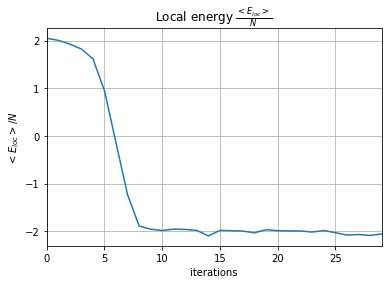

In [6]:
%matplotlib inline
import pandas as pd
ax = pd.Series(block_E).plot(title=r'Local energy $\frac{<E_{loc}>}{N}$',grid=True)
ax.set_ylabel(r'$<E_{loc}>/N$')
ax.set_xlabel('iterations')

## Exact solution

Find the exact ground state energy by constructing all $H_{ij}=\left<s_i\right|H\left| s_j\right>$

In [7]:
from itertools import product

basis = list(product([-1,1],repeat=N))

print('Generated %d basis functions' % (len(basis)))
#print(len(basis_functions))

#list(permutations([0,1,0,0]))
H = np.zeros((2**N,2**N))
for H_i in range(2**N):
    for H_j in range(2**N):
        H_sum = 0
        for i in range(N):
            if H_i == H_j:
                if i == N-1:
                    H_sum -= basis[H_j][i]*basis[H_j][0]
                else:
                    H_sum -= basis[H_j][i]*basis[H_j][i+1]
                    
            sj = list(basis[H_j])
            sj[i] *= -1
            if H_i == basis.index(tuple(sj)):
                H_sum -= hfield

        H[H_i,H_j] = H_sum
            
print('Ground state energy:', np.min(np.linalg.eigvals(H))/N)

Generated 16 basis functions
Ground state energy: (-2.135779205069854+0j)
